**Importing all the required Dependencies**

In [ ]:
from __future__ import print_function, division
from builtins import range, input
import tensorflow
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

**Connecting to Google Drive for Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive'
# Shifted to local machine so not required

Mounted at /content/drive
/content/drive/My Drive


**Initialization parameters**

In [ ]:
# size to which images are to be resized
IMAGE_SIZE = [224, 224]

# training configuration:
epochs = 10
batch_size = 32
# paths
# For Google Colab - Dataset path
pneumonia_path = 'Datasets/Pneumonia/chest_xray_new/PNEUMONIA'
nonpneumonia_path = 'Datasets/Pneumonia/chest_xray_new/NORMAL'
# For Local - Dataset path
# pneumonia_path = 'chest_xray_new/PNEUMONIA'
# nonpneumonia_path = 'chest_xray_new/NORMAL'
# Using glob to grab images from path .jpg or .jpeg
pneumonia_files = glob(pneumonia_path + '/*')
nonpneumonia_files = glob(nonpneumonia_path + '/*')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Datasets/Pneumonia/chest_xray/train',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
testing_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Datasets/Pneumonia/chest_xray/test',
                                                target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import InceptionV3
inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model_incep = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model_incep.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)
model_incep.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_____________________________

In [ ]:
h = model_incep.fit(
    training_set,
    validation_data = testing_set,
    epochs = 5,
    steps_per_epoch = len(training_set)/32,
    validation_steps = len(testing_set)/32
)

Epoch 1/5
2/5 [==========>...................] - ETA: 1:04 - loss: 2.6646 - accuracy: 0.8438

**Fetching the images from Local**

In [ ]:
# Preparing Labels
pneumonia_labels = []
nonpneumonia_labels = []

pneumonia_images=[]
nonpneumonia_images=[]

import cv2 

for i in range(len(pneumonia_files)):
    image = cv2.imread(pneumonia_files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))
    pneumonia_images.append(image)
    pneumonia_labels.append('Chest_PNEUMONIA')
for i in range(len(nonpneumonia_files)):
    image = cv2.imread(nonpneumonia_files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))
    nonpneumonia_images.append(image)
    nonpneumonia_labels.append('Chest_Non_PNEUMONIA')

**Visualize First 40 Images from Data set**

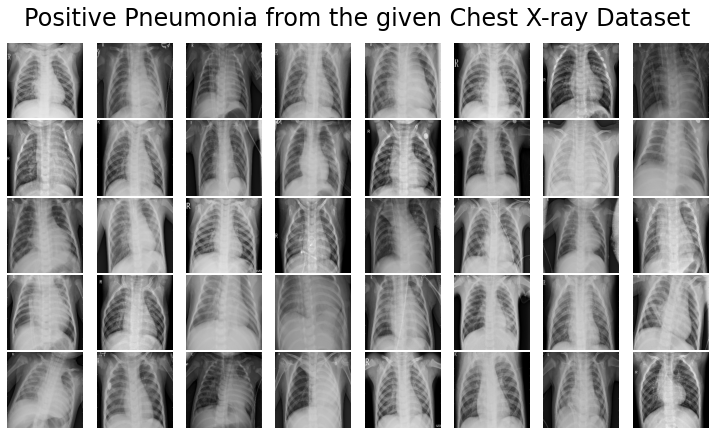

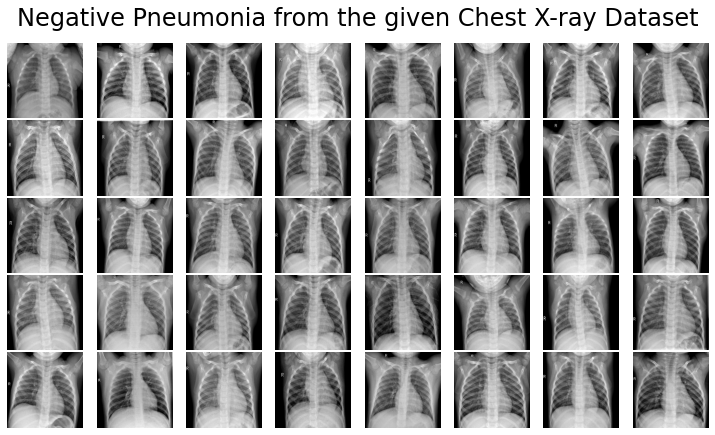

In [ ]:
# Plotting images function
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(pneumonia_images, 'Positive Pneumonia from the given Chest X-ray Dataset')
plot_images(nonpneumonia_images, 'Negative Pneumonia from the given Chest X-ray Dataset')

**Normalization - 
Model takes images in the form of array of pixels. Hence convert into array and normalize**

In [ ]:
# normalize to interval of [0,1]
pneumonia_images = np.array(pneumonia_images) / 255
nonpneumonia_images = np.array(nonpneumonia_images) / 255

**Train Test Split**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
pneumonia_x_train, pneumonia_x_test, pneumonia_y_train, pneumonia_y_test = train_test_split(
    pneumonia_images, pneumonia_labels, test_size=0.2)

In [ ]:
del pneumonia_images

In [ ]:
nonpneumonia_x_train, nonpneumonia_x_test, nonpneumonia_y_train, nonpneumonia_y_test = train_test_split(
    nonpneumonia_images, nonpneumonia_labels, test_size=0.2)
del nonpneumonia_images

In [ ]:
X_train = np.concatenate((nonpneumonia_x_train, pneumonia_x_train), axis=0)
X_test = np.concatenate((nonpneumonia_x_test, pneumonia_x_test), axis=0)
y_train = np.concatenate((nonpneumonia_y_train, pneumonia_y_train), axis=0)
y_test = np.concatenate((nonpneumonia_y_test, pneumonia_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

**Visualize a few images from Training and Test sets**

In [ ]:
plot_images(pneumonia_x_train, 'X_train')
plot_images(nonpneumonia_x_train, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing Pneumonia and NonPneumonia for X_train and X_test

**Building and Visualizing model**

In [ ]:
res = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = res.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=res.input, outputs=outputs)

for layer in res.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

**Training the model**

In [ ]:
import time
start_time = time.time()
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=30)
end_time = time.time()
print(end_time - start_time)

Epoch 1/30
147/146 [==============================] - 533s 4s/step - loss: 1.0001 - accuracy: 0.7141 - val_loss: 0.7428 - val_accuracy: 0.7423
Epoch 2/30
147/146 [==============================] - 519s 4s/step - loss: 0.6168 - accuracy: 0.7684 - val_loss: 0.3845 - val_accuracy: 0.8294
Epoch 3/30
147/146 [==============================] - 481s 3s/step - loss: 0.6440 - accuracy: 0.7786 - val_loss: 0.3351 - val_accuracy: 0.8618
Epoch 4/30
147/146 [==============================] - 491s 3s/step - loss: 0.6418 - accuracy: 0.7829 - val_loss: 0.3563 - val_accuracy: 0.8558
Epoch 5/30
147/146 [==============================] - 635s 4s/step - loss: 0.6819 - accuracy: 0.7889 - val_loss: 0.3152 - val_accuracy: 0.8746
Epoch 6/30
147/146 [==============================] - 718s 5s/step - loss: 0.5992 - accuracy: 0.8019 - val_loss: 0.4462 - val_accuracy: 0.8285
Epoch 7/30
147/146 [==============================] - 766s 5s/step - loss: 0.6335 - accuracy: 0.7948 - val_loss: 0.8503 - val_accuracy: 0.7261

In [ ]:
model.save('resnet_pneu_chest.h5')

In [ ]:
model.save_weights('resnetpneu_weights_chest.hdf5')

In [ ]:
model = load_model('resnet_pneu_chest.h5')

In [ ]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_df['epoch_id'] = [i for i in range (1,len(hist_df)+1)]
hist_df=hist_df.reindex(columns= ['epoch_id', 'loss', 'accuracy','val_loss','val_accuracy'])
print(hist_df)
writer = pd.ExcelWriter('output.xlsx')
# write dataframe to excel
hist_df.to_excel(writer)
# save the excel
writer.save()

    epoch_id      loss  accuracy  val_loss  val_accuracy
0          1  1.000143  0.714133  0.742806      0.742321
1          2  0.616760  0.768360  0.384469      0.829352
2          3  0.644025  0.778608  0.335104      0.861775
3          4  0.641785  0.782878  0.356334      0.855802
4          5  0.681875  0.788856  0.315246      0.874573
5          6  0.599223  0.801879  0.446222      0.828498
6          7  0.633541  0.794833  0.850255      0.726109
7          8  0.647259  0.801238  0.299959      0.877986
8          9  0.900677  0.776900  0.355146      0.883106
9         10  0.830855  0.796328  0.322875      0.889932
10        11  0.727183  0.802733  0.655537      0.797782
11        12  0.820479  0.801665  0.401981      0.872014
12        13  0.593152  0.826217  0.271809      0.902730
13        14  0.608643  0.822161  0.257286      0.906997
14        15  0.631065  0.816396  0.332451      0.878840
15        16  0.770684  0.801879  0.423263      0.865188
16        17  0.634513  0.82600

**Making Predicions**

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

**Visualising First 10 predictions**

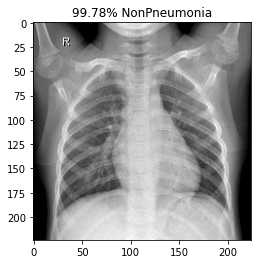

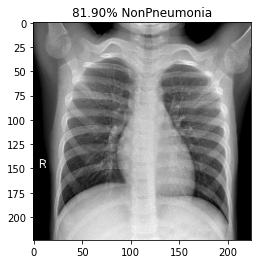

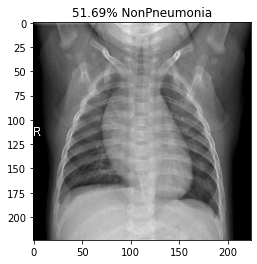

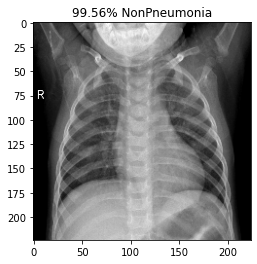

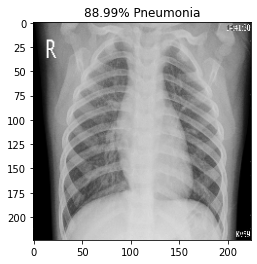

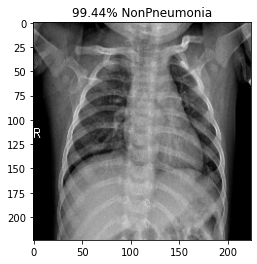

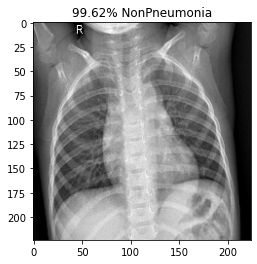

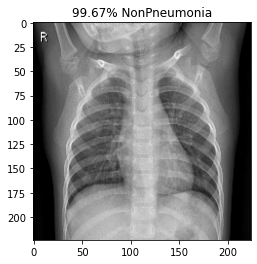

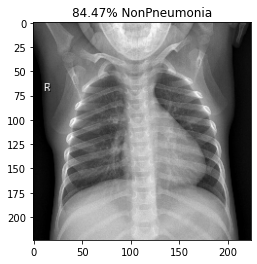

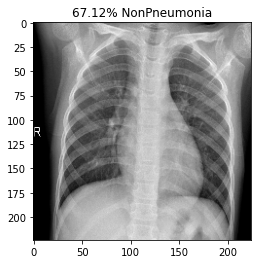

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
    if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% Pneumonia')
    else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonPneumonia')
    plt.imshow(X_test[index])
    plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

**Plot ROC Curve**

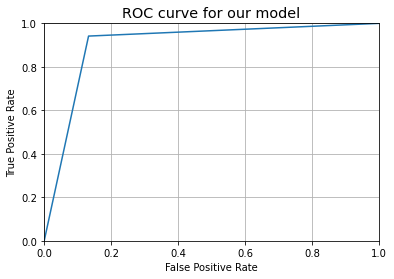

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

**Plot Confusion Matrix**

Confusion Matrix without Normalization


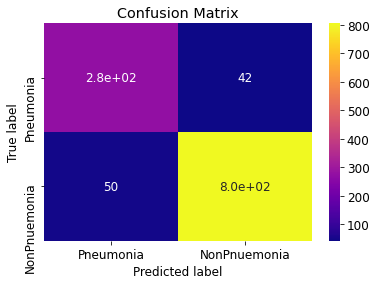

Confusion Matrix with Normalized Values


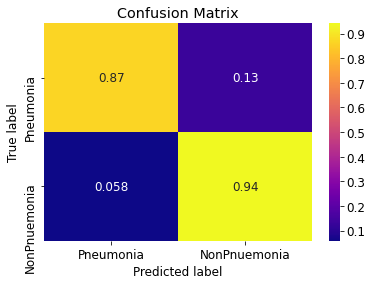

In [ ]:
def plot_confusion_matrix(normalize):
    classes = ['Pneumonia','NonPnuemonia']
    tick_marks = [0.5,1.5]
    cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
    sns.heatmap(cn,cmap='plasma',annot=True)
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

**Classification Report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       317
           1       0.95      0.94      0.95       855

    accuracy                           0.92      1172
   macro avg       0.90      0.90      0.90      1172
weighted avg       0.92      0.92      0.92      1172



**Accuracy and Loss Plots**

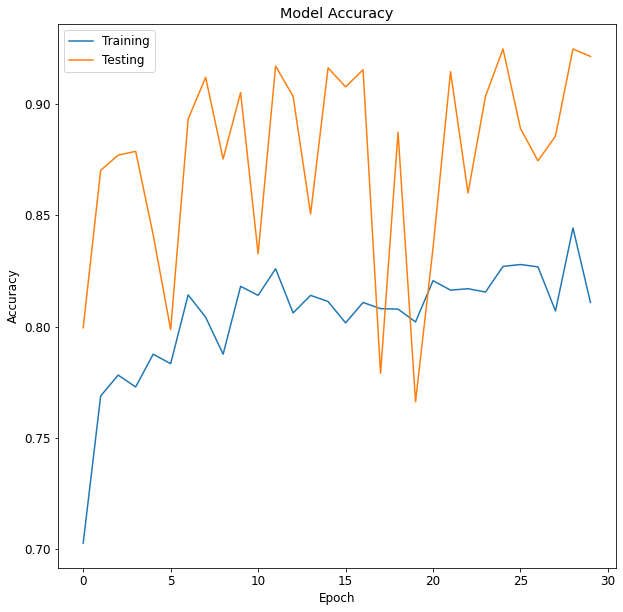

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_pneu_chest_accuracy.png')
plt.show()

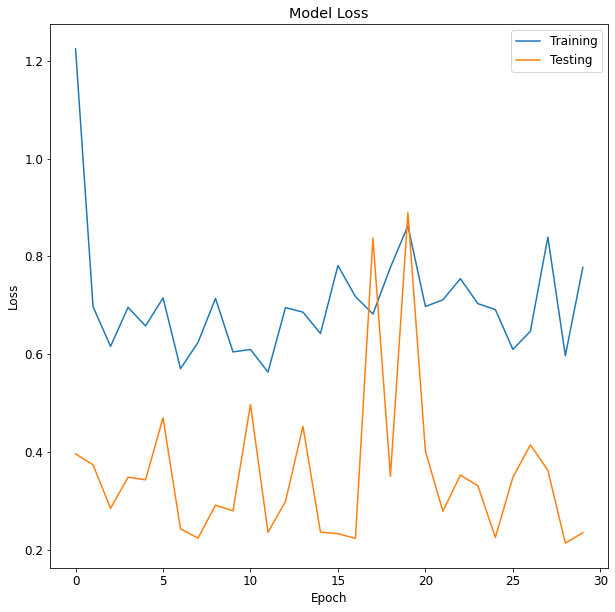

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_pneu_chest_loss.png')
plt.show()

In [ ]:
import time
start_time = time.time()
# your code here 
time.sleep(5)
end_time = time.time()
print(end_time - start_time)

5.006285905838013


# inception

In [ ]:
from tensorflow.keras.applications import InceptionV3
inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model_incep = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model_incep.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)
model_incep.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

Trainable params: 102,402
Non-trainable params: 21,802,784
__________________________________________________________________________________________________


In [ ]:
start_time2 = time.time()
history2 = model_incep.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=30)
end_time2 = time.time()
print(end_time2 - start_time2)

Epoch 1/30
147/146 [==============================] - 368s 3s/step - loss: 0.9277 - accuracy: 0.8674 - val_loss: 0.5634 - val_accuracy: 0.9044
Epoch 2/30
147/146 [==============================] - 343s 2s/step - loss: 1.1252 - accuracy: 0.8939 - val_loss: 1.0122 - val_accuracy: 0.8797
Epoch 3/30
147/146 [==============================] - 293s 2s/step - loss: 1.0877 - accuracy: 0.8999 - val_loss: 0.6530 - val_accuracy: 0.9189
Epoch 4/30
147/146 [==============================] - 272s 2s/step - loss: 1.0213 - accuracy: 0.9093 - val_loss: 0.6227 - val_accuracy: 0.9317
Epoch 5/30
147/146 [==============================] - 261s 2s/step - loss: 0.8416 - accuracy: 0.9214 - val_loss: 0.9121 - val_accuracy: 0.9070
Epoch 6/30
147/146 [==============================] - 257s 2s/step - loss: 1.1235 - accuracy: 0.9093 - val_loss: 1.2655 - val_accuracy: 0.8874
Epoch 7/30
147/146 [==============================] - 258s 2s/step - loss: 1.1443 - accuracy: 0.9108 - val_loss: 0.8210 - val_accuracy: 0.9241

In [ ]:
model.save('inception_pneu_chest.h5')
model.save_weights('inceptionpneu_weights_chest.hdf5')

In [ ]:
import pandas as pd
hist_df = pd.DataFrame(history2.history)
hist_df['epoch_id'] = [i for i in range (1,len(hist_df)+1)]
hist_df=hist_df.reindex(columns= ['epoch_id', 'loss', 'accuracy','val_loss','val_accuracy'])
print(hist_df)
writer = pd.ExcelWriter('output.xlsx')
# write dataframe to excel
hist_df.to_excel(writer)
# save the excel
writer.save()

    id      loss  accuracy  val_loss  val_accuracy
0    1  0.927695  0.867421  0.563371      0.904437
1    2  1.125237  0.893894  1.012216      0.879693
2    3  1.087656  0.899872  0.652961      0.918942
3    4  1.021259  0.909266  0.622657      0.931741
4    5  0.841624  0.921435  0.912149      0.906997
5    6  1.123532  0.909266  1.265456      0.887372
6    7  1.144269  0.910760  0.820952      0.924061
7    8  1.106722  0.915670  0.775860      0.928328
8    9  1.060640  0.919940  0.747064      0.935154
9   10  1.111848  0.917378  0.720745      0.939420
10  11  1.367151  0.914389  0.845070      0.937713
11  12  1.061475  0.926986  0.888621      0.930887
12  13  1.453543  0.914603  2.371137      0.843003
13  14  1.179453  0.923143  0.792387      0.940273
14  15  1.585936  0.913962  0.957819      0.936007
15  16  1.165776  0.934031  1.517634      0.896758
16  17  1.414061  0.920794  1.008495      0.938567
17  18  1.436085  0.922716  1.056891      0.938567
18  19  1.436631  0.923143  0.9

# Xception

In [ ]:
from tensorflow.keras.applications import Xception
xception = Xception(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = xception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model_xcep = Model(inputs=xception.input, outputs=outputs)

for layer in xception.layers:
    layer.trainable = False

model_xcep.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)
model_xcep.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [ ]:
import time
start_time3 = time.time()
history3 = model_xcep.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=30)
end_time3 = time.time()
print(end_time3 - start_time3)

Epoch 1/30
147/146 [==============================] - 632s 4s/step - loss: 1.0238 - accuracy: 0.8918 - val_loss: 0.8368 - val_accuracy: 0.8771
Epoch 2/30
147/146 [==============================] - 701s 5s/step - loss: 0.9837 - accuracy: 0.9067 - val_loss: 0.4869 - val_accuracy: 0.9292
Epoch 3/30
147/146 [==============================] - 684s 5s/step - loss: 0.6986 - accuracy: 0.9227 - val_loss: 0.5931 - val_accuracy: 0.9292
Epoch 4/30
147/146 [==============================] - 700s 5s/step - loss: 0.8576 - accuracy: 0.9249 - val_loss: 0.8494 - val_accuracy: 0.9002
Epoch 5/30
147/146 [==============================] - 710s 5s/step - loss: 0.6493 - accuracy: 0.9336 - val_loss: 0.5474 - val_accuracy: 0.9403
Epoch 6/30
147/146 [==============================] - 688s 5s/step - loss: 0.8363 - accuracy: 0.9253 - val_loss: 3.6567 - val_accuracy: 0.7125
Epoch 7/30
147/146 [==============================] - 701s 5s/step - loss: 0.7526 - accuracy: 0.9351 - val_loss: 0.4868 - val_accuracy: 0.9471

In [ ]:
model_xcep.save('xception_pneu_chest.h5')
model_xcep.save_weights('xceptionpneu_weights_chest.hdf5')
import pandas as pd
hist_df = pd.DataFrame(history3.history)
hist_df['epoch_id'] = [i for i in range (1,len(hist_df)+1)]
hist_df=hist_df.reindex(columns= ['epoch_id', 'loss', 'accuracy','val_loss','val_accuracy'])
print(hist_df)
writer = pd.ExcelWriter('output_XCeption.xlsx')
# write dataframe to excel
hist_df.to_excel(writer)
# save the excel
writer.save()

    epoch_id      loss  accuracy  val_loss  val_accuracy
0          1  1.023767  0.891759  0.836768      0.877133
1          2  0.983718  0.906704  0.486855      0.929181
2          3  0.698611  0.922716  0.593101      0.929181
3          4  0.857633  0.924851  0.849438      0.900171
4          5  0.649285  0.933604  0.547379      0.940273
5          6  0.836310  0.925278  3.656669      0.712457
6          7  0.752580  0.935098  0.486762      0.947099
7          8  0.966236  0.925491  1.828827      0.853242
8          9  0.815621  0.935525  0.990816      0.912969
9         10  0.861774  0.934244  3.339148      0.788396
10        11  0.826332  0.937874  0.826080      0.938567
11        12  0.916821  0.928053  1.944160      0.843003
12        13  0.867681  0.937233  0.723037      0.936007
13        14  0.883993  0.935312  0.838896      0.924915
14        15  0.910754  0.933604  0.713023      0.941126
15        16  0.965714  0.928907  1.508005      0.903584
16        17  1.079721  0.93509

# VGG 19

In [ ]:
from tensorflow.keras.applications import VGG19
vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model_vgg = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

model_vgg.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)
model_vgg.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
import time
start_time2 = time.time()
history4 = model_vgg.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=30)
end_time2 = time.time()
print(end_time2 - start_time2)

Epoch 1/30
147/146 [==============================] - 1330s 9s/step - loss: 0.3770 - accuracy: 0.8617 - val_loss: 0.1661 - val_accuracy: 0.9309
Epoch 2/30
147/146 [==============================] - 1308s 9s/step - loss: 0.2286 - accuracy: 0.9073 - val_loss: 0.1465 - val_accuracy: 0.9445
Epoch 3/30
147/146 [==============================] - 1314s 9s/step - loss: 0.2292 - accuracy: 0.9133 - val_loss: 0.1480 - val_accuracy: 0.9428
Epoch 4/30
147/146 [==============================] - 1308s 9s/step - loss: 0.2232 - accuracy: 0.9174 - val_loss: 0.1560 - val_accuracy: 0.9437
Epoch 5/30
147/146 [==============================] - 1315s 9s/step - loss: 0.2440 - accuracy: 0.9116 - val_loss: 0.2338 - val_accuracy: 0.9155
Epoch 6/30
147/146 [==============================] - 1308s 9s/step - loss: 0.2253 - accuracy: 0.9214 - val_loss: 0.2985 - val_accuracy: 0.9002
Epoch 7/30
147/146 [==============================] - 1306s 9s/step - loss: 0.2240 - accuracy: 0.9266 - val_loss: 0.1423 - val_accuracy:

In [ ]:
model_vgg.save('vgg_pneu_chest.h5')
model_vgg.save_weights('vgg_pneu_weights_chest.hdf5')
import pandas as pd
hist_df = pd.DataFrame(history4.history)
hist_df['epoch_id'] = [i for i in range (1,len(hist_df)+1)]
hist_df=hist_df.reindex(columns= ['epoch_id', 'loss', 'accuracy','val_loss','val_accuracy'])
print(hist_df)
writer = pd.ExcelWriter('output_vgg.xlsx')
# write dataframe to excel
hist_df.to_excel(writer)
# save the excel
writer.save()

    epoch_id      loss  accuracy  val_loss  val_accuracy
0          1  0.376969  0.861657  0.166091      0.930887
1          2  0.228633  0.907344  0.146478      0.944539
2          3  0.229177  0.913322  0.148015      0.942833
3          4  0.223220  0.917378  0.156022      0.943686
4          5  0.243987  0.911614  0.233843      0.915529
5          6  0.225285  0.921435  0.298482      0.900171
6          7  0.223998  0.926558  0.142264      0.953072
7          8  0.246048  0.918232  0.280553      0.905290
8          9  0.235474  0.925491  0.127634      0.953925
9         10  0.290178  0.917165  0.148652      0.954778
10        11  0.247299  0.921008  0.241506      0.923208
11        12  0.212830  0.932750  0.129799      0.959044
12        13  0.263033  0.919940  0.140634      0.954778
13        14  0.259223  0.925705  0.144130      0.950512
14        15  0.228160  0.930188  0.196783      0.930887
15        16  0.249680  0.924637  0.127604      0.956485
16        17  0.230498  0.92890

# Efficient Net

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
model_EfficientNet = EfficientNetB0(weights='imagenet',include_top=False,input_tensor=Input(shape=(224, 224, 3)))
outputs = model_EfficientNet.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model_en = Model(inputs=model_EfficientNet.input, outputs=outputs)

for layer in model_en.layers:
    layer.trainable = False

model_en.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)
model_en.summary()

In [ ]:
import time
start_time2 = time.time()
history5 = model_en.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=30)
end_time2 = time.time()
print(end_time2 - start_time2)

In [ ]:
from tensorflow.keras.applications import DenseNet201
model_DenseNet201 = DenseNet201(weights='imagenet',include_top=False,input_tensor=Input(shape=(224, 224, 3)))
outputs = model_DenseNet201.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model_DE = Model(inputs=model_DenseNet201.input, outputs=outputs)

for layer in model_DE.layers:
    layer.trainable = False

model_DE.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)
model_DE.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

conv4_block10_concat (Concatena (None, 14, 14, 576)  0           conv4_block9_concat[0][0]        
                                                                 conv4_block10_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block11_0_bn (BatchNormal (None, 14, 14, 576)  2304        conv4_block10_concat[0][0]       
__________________________________________________________________________________________________
conv4_block11_0_relu (Activatio (None, 14, 14, 576)  0           conv4_block11_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block11_1_conv (Conv2D)   (None, 14, 14, 128)  73728       conv4_block11_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block11_1_bn (BatchNormal (None, 14, 14, 128)  512         conv4_block11_1_conv[0][0]       
__________

conv5_block14_concat (Concatena (None, 7, 7, 1344)   0           conv5_block13_concat[0][0]       
                                                                 conv5_block14_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block15_0_bn (BatchNormal (None, 7, 7, 1344)   5376        conv5_block14_concat[0][0]       
__________________________________________________________________________________________________
conv5_block15_0_relu (Activatio (None, 7, 7, 1344)   0           conv5_block15_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block15_1_conv (Conv2D)   (None, 7, 7, 128)    172032      conv5_block15_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block15_1_bn (BatchNormal (None, 7, 7, 128)    512         conv5_block15_1_conv[0][0]       
__________

In [ ]:
import time
start_time2 = time.time()
history6 = model_DE.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=30)
end_time2 = time.time()
print(end_time2 - start_time2)

Epoch 1/30
147/146 [==============================] - 873s 6s/step - loss: 0.9757 - accuracy: 0.5796 - val_loss: 0.6869 - val_accuracy: 0.6237
Epoch 2/30
147/146 [==============================] - 873s 6s/step - loss: 0.9916 - accuracy: 0.5705 - val_loss: 0.6869 - val_accuracy: 0.6237
Epoch 3/30
147/146 [==============================] - 1014s 7s/step - loss: 0.9344 - accuracy: 0.5907 - val_loss: 0.6869 - val_accuracy: 0.6237
Epoch 4/30
147/146 [==============================] - 997s 7s/step - loss: 0.9637 - accuracy: 0.5824 - val_loss: 0.6869 - val_accuracy: 0.6237
Epoch 5/30
147/146 [==============================] - 964s 7s/step - loss: 0.9998 - accuracy: 0.5587 - val_loss: 0.6869 - val_accuracy: 0.6237
Epoch 6/30
147/146 [==============================] - 731s 5s/step - loss: 0.9692 - accuracy: 0.5698 - val_loss: 0.6869 - val_accuracy: 0.6237
Epoch 7/30
147/146 [==============================] - 784s 5s/step - loss: 0.9694 - accuracy: 0.5745 - val_loss: 0.6869 - val_accuracy: 0.623

In [ ]:
model_DE.save('densenet201_pneu_chest.h5')
model_DE.save_weights('densenet201_pneu_weights_chest.hdf5')
import pandas as pd
hist_df = pd.DataFrame(history6.history)
hist_df['epoch_id'] = [i for i in range (1,len(hist_df)+1)]
hist_df=hist_df.reindex(columns= ['epoch_id', 'loss', 'accuracy','val_loss','val_accuracy'])
print(hist_df)
writer = pd.ExcelWriter('output_DesnseNet201.xlsx')
# write dataframe to excel
hist_df.to_excel(writer)
# save the excel
writer.save()

    epoch_id      loss  accuracy  val_loss  val_accuracy
0          1  0.975698  0.579633  0.686927       0.62372
1          2  0.991583  0.570453  0.686927       0.62372
2          3  0.934364  0.590734  0.686927       0.62372
3          4  0.963674  0.582408  0.686927       0.62372
4          5  0.999783  0.558711  0.686927       0.62372
5          6  0.969230  0.569812  0.686927       0.62372
6          7  0.969444  0.574509  0.686927       0.62372
7          8  0.972413  0.574722  0.686927       0.62372
8          9  0.982980  0.564688  0.686927       0.62372
9         10  0.985879  0.573014  0.686927       0.62372
10        11  0.985740  0.568531  0.686927       0.62372
11        12  0.949364  0.578779  0.686927       0.62372
12        13  0.980300  0.568104  0.686927       0.62372
13        14  0.977906  0.573655  0.686927       0.62372
14        15  0.977905  0.582835  0.686927       0.62372
15        16  0.989070  0.577498  0.686927       0.62372
16        17  0.967935  0.57450

# MobileNetV3Large

In [ ]:
model_MobileNetLarge = tensorflow.keras.applications.MobileNetV3Large(weights='imagenet',include_top=False,input_tensor=Input(shape=(224, 224, 3)))
outputs = model_MobileNetLarge.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model_MN = Model(inputs=model_MobileNetLarge.input, outputs=outputs)

for layer in model_MN.layers:
    layer.trainable = False

model_MN.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)
model_MN.summary()

AttributeError: module 'tensorflow.keras.applications' has no attribute 'MobileNetV3Large'

In [ ]:
import time
start_time2 = time.time()
history7 = model_MN.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=30)
end_time2 = time.time()
print(end_time2 - start_time2)

In [ ]:
model_MN.save('mobilenetv3large_pneu_chest.h5')
model_MN.save_weights('mobilenetv3large_pneu_weights_chest.hdf5')
import pandas as pd
hist_df = pd.DataFrame(history7.history)
hist_df['epoch_id'] = [i for i in range (1,len(hist_df)+1)]
hist_df=hist_df.reindex(columns= ['epoch_id', 'loss', 'accuracy','val_loss','val_accuracy'])
print(hist_df)
writer = pd.ExcelWriter('output_mobilenetv3large.xlsx')
# write dataframe to excel
hist_df.to_excel(writer)
# save the excel
writer.save()

# InceptionResnetv2

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
model_InceptionResNetV2 = InceptionResNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224, 224, 3)))
outputs = model_InceptionResNetV2.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model_IR = Model(inputs=model_InceptionResNetV2.input, outputs=outputs)

for layer in model_IR.layers:
    layer.trainable = False

model_IR.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)
model_IR.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
import time
start_time2 = time.time()
history8 = model_IR.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=30)
end_time2 = time.time()
print(end_time2 - start_time2)

Epoch 1/30
147/146 [==============================] - 603s 4s/step - loss: 1.4230 - accuracy: 0.6650 - val_loss: 1.0692 - val_accuracy: 0.7278
Epoch 2/30
147/146 [==============================] - 611s 4s/step - loss: 1.3617 - accuracy: 0.6670 - val_loss: 1.0692 - val_accuracy: 0.7278
Epoch 3/30
147/146 [==============================] - 696s 5s/step - loss: 1.4038 - accuracy: 0.6652 - val_loss: 1.0692 - val_accuracy: 0.7278
Epoch 4/30
 43/146 [=======>......................] - ETA: 6:42 - loss: 1.3283 - accuracy: 0.6777

KeyboardInterrupt: 

In [ ]:
model_IR.save('incepresnet_pneu_chest.h5')
model_IR.save_weights('incepresnet_pneu_weights_chest.hdf5')
import pandas as pd
hist_df = pd.DataFrame(history8.history)
hist_df['epoch_id'] = [i for i in range (1,len(hist_df)+1)]
hist_df=hist_df.reindex(columns= ['epoch_id', 'loss', 'accuracy','val_loss','val_accuracy'])
print(hist_df)
writer = pd.ExcelWriter('output_incepresnet.xlsx')
# write dataframe to excel
hist_df.to_excel(writer)
# save the excel
writer.save()

# ResNet101V2

In [ ]:
from tensorflow.keras.applications import ResNet101V2
model_ResNet101V2 = ResNet101V2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224, 224, 3)))
outputs = model_ResNet101V2.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model_IR = Model(inputs=model_ResNet101V2.input, outputs=outputs)

for layer in model_IR.layers:
    layer.trainable = False

model_IR.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)
model_IR.summary()

171319296/171317808 [==============================] - 25s 0us/step
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
___________________

In [ ]:
import time
start_time2 = time.time()
history8 = model_IR.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=30)
end_time2 = time.time()
print(end_time2 - start_time2)

Epoch 1/30
147/146 [==============================] - 846s 6s/step - loss: 2.3404 - accuracy: 0.4560 - val_loss: 1.3816 - val_accuracy: 0.4608
Epoch 2/30
147/146 [==============================] - 825s 6s/step - loss: 2.4183 - accuracy: 0.4524 - val_loss: 1.3816 - val_accuracy: 0.4608
Epoch 3/30
147/146 [==============================] - 826s 6s/step - loss: 2.3626 - accuracy: 0.4584 - val_loss: 1.3816 - val_accuracy: 0.4608
Epoch 4/30
 43/146 [=======>......................] - ETA: 7:31 - loss: 2.4037 - accuracy: 0.4549

KeyboardInterrupt: 

In [ ]:
model_IR.save('ResNet101V2_pneu_chest.h5')
model_IR.save_weights('ResNet101V2_pneu_weights_chest.hdf5')
import pandas as pd
hist_df = pd.DataFrame(history8.history)
hist_df['epoch_id'] = [i for i in range (1,len(hist_df)+1)]
hist_df=hist_df.reindex(columns= ['epoch_id', 'loss', 'accuracy','val_loss','val_accuracy'])
print(hist_df)
writer = pd.ExcelWriter('output_ResNet101V2.xlsx')
# write dataframe to excel
hist_df.to_excel(writer)
# save the excel
writer.save()